In [1]:
from fitburst.analysis.model import SpectrumModeler
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from scipy.special import erfc
from chime_frb_constants import K_DM, FREQ_BOTTOM_MHZ, FREQ_TOP_MHZ

In [5]:
failed_events = [22457855, 25660576, 27112562, 31938812, 32158184, 33769804, 37888771, 38547575, 39218186, 41507681, 41597828, 42295086]

print(len(failed_events))

#### Re-run models for these events and re-generate their waterfalls #####

12


In [2]:
def get_meta_param(fit_input):
    file_path_input = fit_input

    data_input = np.load(file_path_input, allow_pickle = True)
    data_npz = data_input['data_full']
    mdata = data_input['metadata']
    metadata = mdata.item()

    ### Getting file size ####
    res_freq = metadata['res_freq']
    res_time = metadata['res_time']
    num_freq = metadata['num_freq']
    num_time = metadata['num_time']
    is_dedispersed = metadata['is_dedispersed']
    freq0 = metadata['freqs_bin0']
    freq1 = freq0 + num_freq * res_freq
    time0 = metadata['times_bin0']
    time1 = time0 + num_time * res_time

    freqs = np.arange(freq0, freq1, res_freq)
    times = np.arange(time0, time1, res_time)
    
    return freqs, times, data_npz

def get_model_params(file_path):
    try:
        f = open(file_path)
    except:
        print("No file", file_path)
        return None
    data = json.load(f)
    best_params = data['model_parameters']
    
    return best_params

def get_model(freqs, times, best_params, data_npz = None, scint = False):
    
    num_components = len(best_params["dm"])
    is_dedispersed = True
    scint = scint


    params = {                                                     
        "amplitude"            : best_params['amplitude'],
        "arrival_time"         : best_params['arrival_time'],
        "burst_width"          : best_params['burst_width'],
        "dm"                   : [0.] * num_components,
        "dm_index"             : [-2.] * num_components,
        "ref_freq"             : [600.] * num_components,
        "scattering_index"     : [-4.] * num_components,
        "scattering_timescale" : best_params['scattering_timescale'] * num_components,
        "spectral_index"       : best_params['spectral_index'],
        "spectral_running"     : best_params['spectral_running'],
    } 
    
    t_arr = best_params['arrival_time']

    if scint:
        scintillation = True
        model_obj = SpectrumModeler(freqs,
                                times,
                                is_dedispersed = is_dedispersed,
                                num_components = num_components,
                                verbose = True,
                                scintillation = scintillation,
                               )
        model_obj.update_parameters(params)
        model = model_obj.compute_model(data = data_npz)
    else:
        scintillation = False
        model_obj = SpectrumModeler(freqs,
                                times,
                                is_dedispersed = is_dedispersed,
                                num_components = num_components,
                                verbose = True,
                                scintillation = scintillation,
                               )
        model_obj.update_parameters(params)
        model = model_obj.compute_model()
        
    return model, t_arr

def plot_model(freqs, times, model, t_arr):
    
    plt.pcolormesh(times, freqs, model)
    for i in range(len(t_arr)):
        plt.axvline(t_arr[i], c='w', linestyle='--')
    plt.xlabel("Time (s)")
    plt.ylabel("Observing Frequency (MHz)")
    plt.show()
    
def plot_profile_model(times, model, t_arr):
    plt.plot(times, model, color='r')
    for i in range(len(t_arr)):
        plt.axvline(t_arr[i], color='gray', alpha=0.5) 
    plt.xlabel("Time (s)")
    plt.ylabel("S/N")
    plt.show()
    
def sum_emg(x: np.ndarray, *args) -> np.ndarray:
    """
    Calculates a sum of EMGs

    Parameters
    ----------
    x : np.ndarray
        Time in s at every time bin
    args : np.ndarray
        Parameters of all the EMGs to be summed
        ordered as: a1, mu1, sigma1, a2, mu2, sigma2, etc.

    Returns
    -------
    emg : np.ndarray
        Sum of EMGs each scaled by an amplitude.
    """
    if type(args) != list:
        args = np.array(args).flatten()
        args = list(args)
    scat = args.pop(-1)
    args = np.array(args).flatten()
    num_g = int(len(args) / 3)
    args = args.reshape((num_g, 3))
    a, mu, sigma = args[..., 0], args[..., 1], args[..., 2]
    emg = np.zeros(len(x))
    for i in range(num_g):
        emg += a[i] * exponorm(x, 1 / scat, mu[i], sigma[i])
    if np.isnan(emg).any() or np.isinf(emg).any():
        emg = np.zeros(len(x))
    return emg, mu

def exponorm(x: np.ndarray, lam: float, mu: float, sigma: float) -> np.ndarray:
    """
    Calculate the exponentially modified gaussian (EMG) for the given
    input x and parameters lam, mu, and sigma.

    Parameters
    ----------
    x : np.ndarray
        Time in s at every time bin
    lam : float
        Inverse of the exponent relaxation time
    mu : float
        Gaussian mean
    sigma : float
        Gaussian std. For more info, see:
        https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution

    Returns
    -------
    np.ndarray
        Exponentially modified Gaussian PDF for given params.
    """
    I = lam / 2 * np.exp(lam / 2 * (2 * mu + lam * sigma**2 - 2 * x))
    II = erfc((mu + lam * sigma**2 - x) / (2**0.5 * sigma))
    return I * II


def rpl(f: np.ndarray, *pars) -> np.ndarray:
    """
    Calculates running power-law model given input parameters and independent variable.

    Parameters
    ----------
    f : np.ndarray
        Array of the frequency in MHz of every channel
    pars : np.ndarray
        Array with the parameters of the running power-law model,
        with order amplitude, rpl spectral index, spectral running.
    Returns
    -------
    np.ndarray
        Running-power law for given parameters evaluated at input f.
    """
    pars = np.array(pars).flatten()
    A, index, running = pars[0], pars[1], pars[2]
    ref_freq = 600.0
    model_rpl =  A * (f / ref_freq) ** (-index + running * np.log(f / ref_freq))
    return model_rpl

def get_spectrum(power: np.ndarray) -> np.ndarray:
    """
    Computes the normalized spectrum

    Parameters
    ----------
    power : np.ndarray
        2D (nfreq, ntime) power

    Returns
    -------
    np.ndarray
        Spectrum of the burst
    """
    return np.sum(power, axis=-1) / np.sqrt(power.shape[-1])

In [3]:
basepath = '/arc/home/ksand/Basecat_morph/DM_struct_max/run4/'
entries = os.listdir(basepath)

entries.remove('41365524')  ### This is the event id where we can't see the burst or the burst is too weak ######
entries.remove('42842438') ### This is the event id where we can't see the burst or the burst is too weak ######
entries.remove('42637411') ### This is the event id where we can't see the burst or the burst is too weak ######

entries = np.array(entries)
entries = np.sort(entries)

print(entries.shape)

(137,)


In [4]:
failed_events = [22457855, 25660576, 27112562, 31938812, 32158184, 33769804, 37888771, 38547575, 39218186, 41507681, 41597828, 42295086]


idx = np.where(entries == '37338232')[0][0]
print(idx)

70


Running event 31938812
(1024, 586) (586,)
(1024, 586) (586,)
Generating Scintillation Model
0.00000 0.00433  -4.00000  0.00004  0.00035 
0.00000 0.00552  -4.00000  0.00004  0.00009 
0.00000 0.00642  -4.00000  0.00004  0.00085 


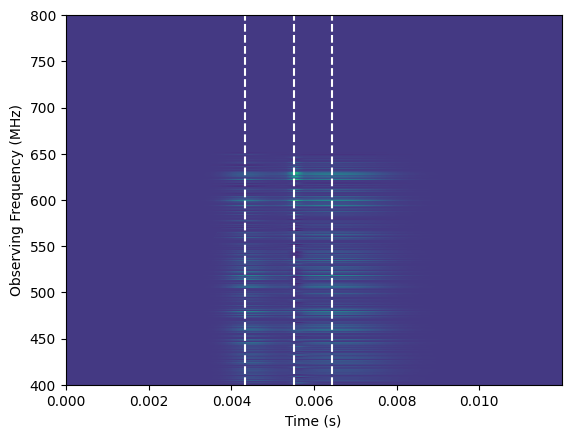

Generating No Scattering Model
0.00000  -0.79579  0.00436   -4.00000  0.00000  0.00042 -8.46580  -15.69353
0.00000  -21.11852  0.00616   -4.00000  0.00000  0.00104 2187.54603  -24457.47886
0.00000  -0.54847  0.00641   -4.00000  0.00000  0.00079 -4.79264  -10.69722
(1024, 586)


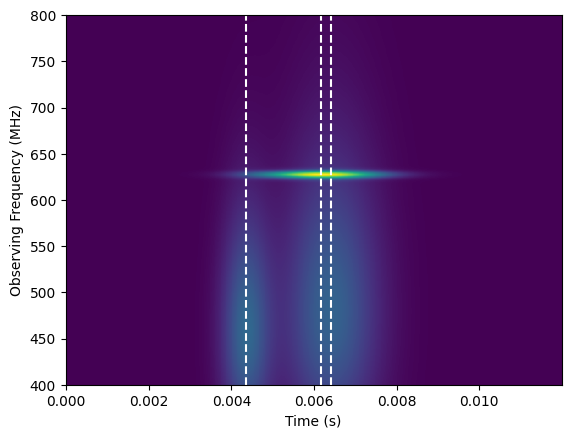

Generating Scattering Model
0.00000  -0.22753  0.00407   -4.00000  0.00029  0.00021 -6.51034  -7.88578
0.00000  -0.25001  0.00532   -4.00000  0.00029  0.00005 37.15062  -522.07537
0.00000  -0.14437  0.00594   -4.00000  0.00029  0.00014 -0.32809  -0.98403
0.00000  -0.70152  0.00588   -4.00000  0.00029  0.00081 -19.98893  -44.49935
0.00000  -0.18383  0.00681   -4.00000  0.00029  0.00037 6.19120  15.15748


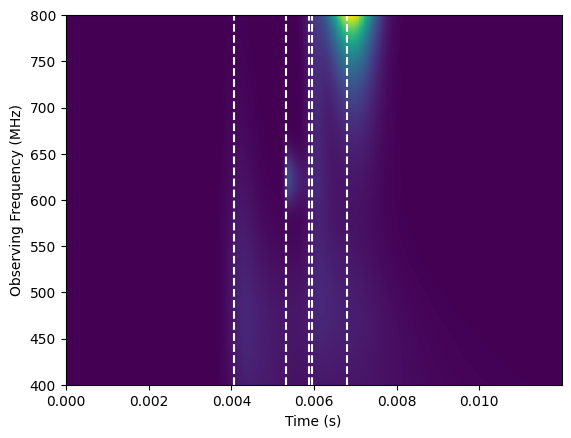

In [61]:
path = '/arc/home/ksand/Basecat_morph/fitburst_runs/fitburst_run4/'
failed_file = []

for i in range(idx,idx+1):
    print("Running event", entries[i])
    event_path = os.path.join(path, str(entries[i]))
    fit_input = event_path + '/fitburst_input_{}_no_scat.npz'.format(entries[i])    
    freqs, times, data_npz = get_meta_param(fit_input)
    
    print(data_npz.shape, times.shape)
    
    if data_npz.shape[-1] != times.shape[0]:
        print("Yo time and data shape not matchin maan, doing adjust don't you worry child")
        times = np.delete(times, -1)
        
    print(data_npz.shape, times.shape)
    
    

    ##### Generating scintillation model #######
    print("Generating Scintillation Model")

    file_path_scint = event_path + '/results_fitburst_scat_scint_{}.json'.format(entries[i])
    best_params = get_model_params(file_path_scint)
    
    if best_params is not None:
        model, t_arr = get_model(freqs, times, best_params, data_npz, True)
        plot_model(freqs, times, model, t_arr)

        oname = '/model_scint_{}.npz'.format(entries[i])
        save_path = event_path + oname
        np.savez(save_path, data = data_npz, model = model, freqs = freqs, times = times, arrival_time = t_arr)
    else:
        failed_file.append(file_path_scint)


    ###### Generating no scattering model ########
    print("Generating No Scattering Model")

    file_path_no_scat = event_path + '/results_fitburst_no_scat_{}.json'.format(entries[i])
    best_params = get_model_params(file_path_no_scat)
    if best_params is not None:
        model, t_arr = get_model(freqs, times, best_params)
        
        print(model.shape)
        plot_model(freqs, times, model, t_arr)

        oname = '/model_no_scat_{}.npz'.format(entries[i])
        save_path = event_path + oname
        np.savez(save_path, data = data_npz, model = model, freqs = freqs, times = times, arrival_time = t_arr)
    else:
        failed_file.append(file_path_no_scat)
        
    ###### Generating scattering model #########
    print("Generating Scattering Model")

    file_path_scat = event_path + '/results_fitburst_scat_{}.json'.format(entries[i])
    best_params = get_model_params(file_path_scat)
    if best_params is not None:
        model, t_arr = get_model(freqs, times, best_params)
        plot_model(freqs, times, model, t_arr)

        oname = '/model_scat_{}.npz'.format(entries[i])
        save_path = event_path + oname
        np.savez(save_path, data = data_npz, model = model, freqs = freqs, times = times, arrival_time = t_arr)
    else:
        failed_file.append(file_path_scat)
        
    clear_output(wait=True)
        
    # except:
    #     print("One of the files is missing for event", entries[i])
    #     failed_event.append(entries[i])
    #     clear_output(wait=True)

    

In [9]:
print(failed_file)

['/arc/home/ksand/Basecat_morph/fitburst_runs/fitburst_run4/23438043/results_fitburst_no_scat_23438043.json', '/arc/home/ksand/Basecat_morph/fitburst_runs/fitburst_run4/37888771/results_fitburst_scat_scint_37888771.json']


Running event 37338232


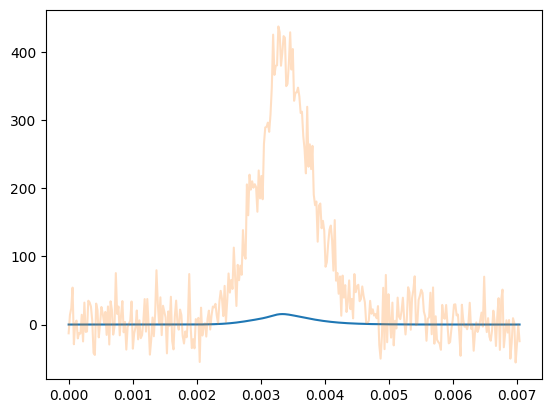

In [8]:
###### Generating profile models ####

path = '/arc/home/ksand/Basecat_morph/fitburst_runs/fitburst_run4/'

for i in range(idx,idx+1):
    print("Running event", entries[i])
    event_path = os.path.join(path, str(entries[i]))
    fit_input = event_path + '/fitburst_input_{}.npz'.format(entries[i])    
    freqs, times, data_npz = get_meta_param(fit_input)
    
    mcmc_file_path = event_path + '/mcmc_best_fit_{}.npz'.format(entries[i])
    # try:
    data_fit = np.load(mcmc_file_path, allow_pickle = True)
    # except:
    #     print("No mcmc fit for this event", entries[i])
    #     data_fit = None

    if data_fit is not None:
        best_params = data_fit['fit']
        
        
        profile = np.sum(data_npz, axis=0)
        

        model, t_arr = sum_emg(times, best_params)
        #plot_profile_model(times, model, t_arr)
        plt.plot(times, model)
        if len(times) != len(profile):
            times = np.delete(times, -1)
        plt.plot(times, profile, alpha = 0.25)
        plt.show()

        oname = '/model_mcmc_profile_{}.npz'.format(entries[i])
        save_path = event_path + oname
        t_arr = np.array([0.00282624, 0.0032768])
        np.savez(save_path, data = data_npz, model = model, freqs = freqs, times = times, arrival_time = t_arr)
    #clear_output(wait=True)
    

Running event 43246206
800.1953125


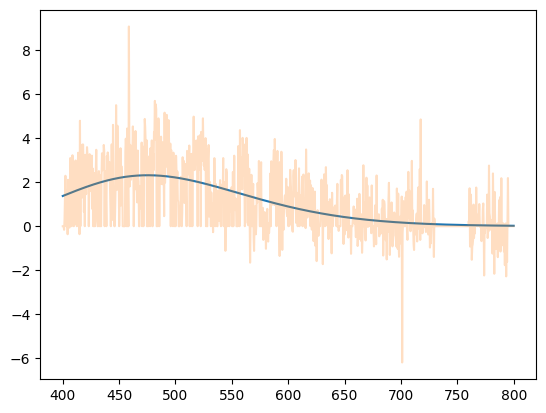

In [88]:
##### Generate Bandwidth Model ########

path = '/arc/home/ksand/Basecat_morph/fitburst_runs/fitburst_run4/'

for i in range(len(entries)):
    print("Running event", entries[i])
    event_path = os.path.join(path, str(entries[i]))
    fit_input = event_path + '/fitburst_input_{}.npz'.format(entries[i])    
    freqs, times, data_npz = get_meta_param(fit_input)
    
    
    spectrum = get_spectrum(data_npz)
    
    
    bw_file_path = event_path + '/{}_bandwidth.npz'.format(entries[i])
    bw_input = np.load(bw_file_path, allow_pickle=True)
    spec_params = bw_input['fit_param']
    top_freq = bw_input['top_available_freq']
    print(top_freq)
    

    low = FREQ_BOTTOM_MHZ
    high = FREQ_TOP_MHZ
    num_chans = 1024
    
    f_res = (high - low) / num_chans
    model_rpl = np.zeros(num_chans)
    
    if top_freq < high:
        num_chans = int((top_freq - low)/f_res)
        print(num_chans)
        freqs_new = np.linspace(low, top_freq, num_chans)
        model_rpl[:num_chans] = rpl(freqs_new, spec_params)
    else:
        model_rpl = rpl(freqs, spec_params)
    
    oname = '/model_bandwidth_{}.npz'.format(entries[i])
    save_path = event_path + oname
    np.savez(save_path, data = data_npz, model = model_rpl, freqs = freqs, spectrum = spectrum)
    
    plt.plot(freqs, model_rpl)
    plt.plot(freqs, spectrum, alpha = 0.25)
    plt.show()
    clear_output(wait=True)